# Portfolio Analysis of Nifty 50 Stocks (2015-2021)

## Introduction

This project analyzes historical stock data for Nifty 50 companies from 2015 to 2021 to construct and evaluate a portfolio. The objectives are to:

1. Analyze indicators of volatility and unpredictability.
2. Select promising stocks based on historical returns.
3. Evaluate correlations between selected stocks for diversification.
4. Visualize the portfolio’s performance compared to a benchmark.
5. Assess the portfolio’s risk through drawdown analysis.

The analysis provides insights into the performance and risk of the selected portfolio, offering recommendations for investors.

## Data Description

The dataset (`NIFTY50_all.csv`) contains historical stock data for Nifty 50 companies from 2007 to 2021. For this analysis, we focus on the period from 2015-03-14 to 2021-04-30 due to data availability. The dataset includes the following columns:

- `Date`: Trading date.
- `Symbol`: Stock ticker symbol.
- `Prev Close`: Previous day’s closing price.
- `Open`, `High`, `Low`, `Close`: Daily price data.
- `Volume`: Trading volume.

Additional columns like `Turnover` and `Trades` are not used in this analysis. A separate metadata file (`stock_metadata.csv`) provides stock symbols and their corresponding industries for diversification analysis.

## Analysis and Results

### Task 1: Analyze Indicators of Volatility and Unpredictability (Last Decade)

#### Objective
Identify the most volatile and unpredictable stocks from 2015-03-14 to 2021-04-30 using metrics like standard deviation of returns, high-low range, and rolling volatility.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [3]:
# Load the data
uploaded = files.upload()
nifty50_df = pd.read_csv('NIFTY50_all.csv')

Saving NIFTY50_all.csv to NIFTY50_all.csv


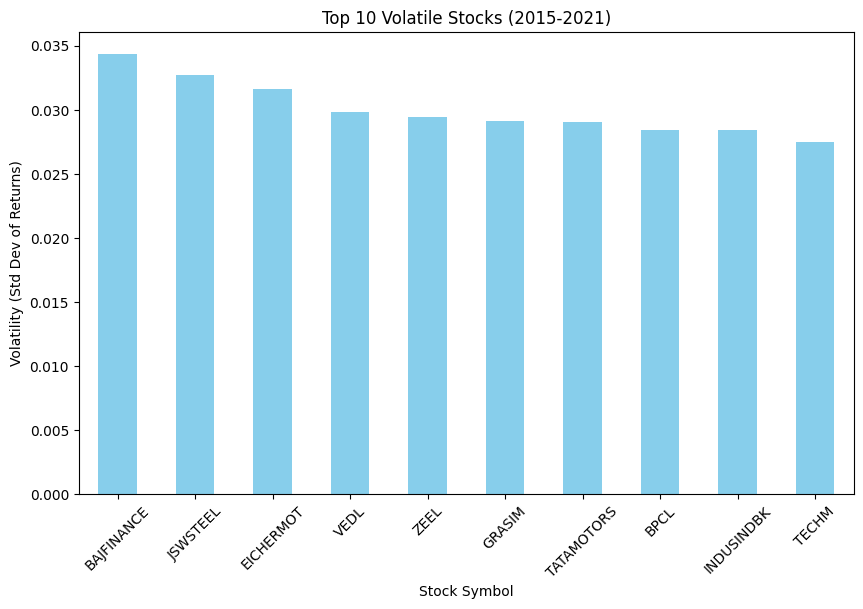

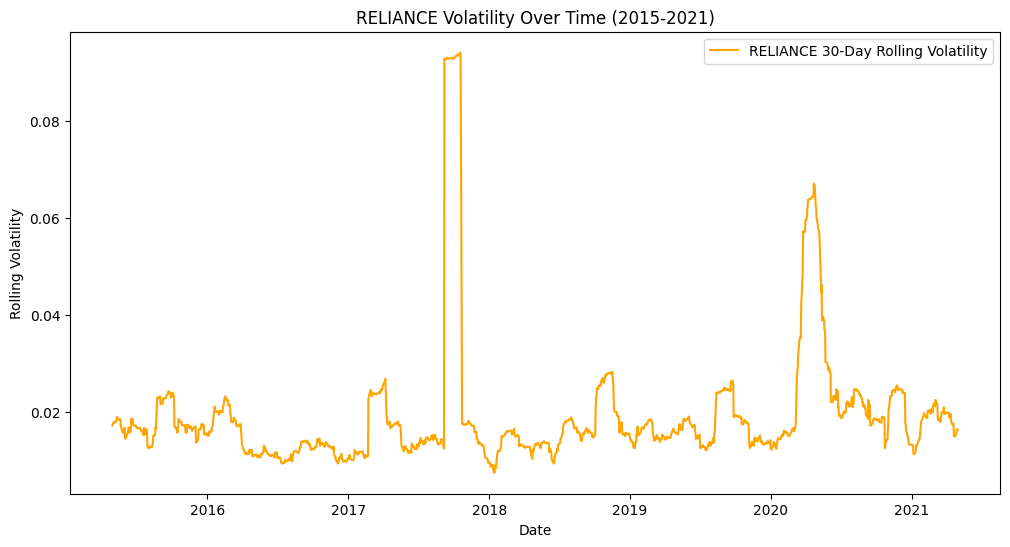

Top 5 Stocks by Volatility:
Symbol
BAJFINANCE    0.034349
JSWSTEEL      0.032701
EICHERMOT     0.031642
VEDL          0.029792
ZEEL          0.029454
Name: Returns, dtype: float64

Average High-Low Range by Stock:
Symbol
SSLT          0.039901
VEDL          0.038441
ZEEL          0.037717
HINDALCO      0.035432
TATAMOTORS    0.035239
Name: HL_Range, dtype: float64


In [4]:
# Convert 'Date' to datetime
nifty50_df['Date'] = pd.to_datetime(nifty50_df['Date'])

# Filter data for the last decade (2015-03-14 to 2021-04-30)
last_decade_df = nifty50_df[(nifty50_df['Date'] >= '2015-03-14') & (nifty50_df['Date'] <= '2021-04-30')].copy()

# Calculate daily returns
last_decade_df['Returns'] = last_decade_df.groupby('Symbol')['Close'].pct_change()

# Indicator 1: Volatility (standard deviation of returns) per stock
volatility = last_decade_df.groupby('Symbol')['Returns'].std().sort_values(ascending=False)

# Indicator 2: High-Low Range (daily fluctuation)
last_decade_df['HL_Range'] = (last_decade_df['High'] - last_decade_df['Low']) / last_decade_df['Prev Close']

# Indicator 3: Rolling Volatility (30-day window)
last_decade_df['Rolling_Vol'] = last_decade_df.groupby('Symbol')['Returns'].rolling(window=30).std().reset_index(level=0, drop=True)

# Visualize top 10 volatile stocks
plt.figure(figsize=(10, 6))
volatility.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Volatile Stocks (2015-2021)')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.xlabel('Stock Symbol')
plt.xticks(rotation=45)
plt.show()

# Rolling volatility for Reliance
sample_stock = 'RELIANCE'
sample_data = last_decade_df[last_decade_df['Symbol'] == sample_stock]
plt.figure(figsize=(12, 6))
plt.plot(sample_data['Date'], sample_data['Rolling_Vol'], label=f'{sample_stock} 30-Day Rolling Volatility', color='orange')
plt.title(f'{sample_stock} Volatility Over Time (2015-2021)')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility')
plt.legend()
plt.show()

# Summary of volatility metrics
print("Top 5 Stocks by Volatility:")
print(volatility.head())
print("\nAverage High-Low Range by Stock:")
print(last_decade_df.groupby('Symbol')['HL_Range'].mean().sort_values(ascending=False).head())

Interpretation

Financial services (BAJFINANCE) and industrial/automotive sectors (JSWSTEEL, EICHERMOT) showed the highest volatility.
Stocks like SSLT (possibly ADANIPORTS), VEDL, and ZEEL had the largest daily price fluctuations.
Reliance’s rolling volatility spiked around 2020, likely due to the COVID-19 market crash.

## Task 2: Choose Promising Stocks for Your Portfolio
### Objective
Select the top 5 stocks with the highest cumulative returns from 2015 to 2021, considering risk-adjusted returns (Sharpe ratio) and industry diversification.

Top 5 Promising Stocks for Portfolio:
       Symbol  Avg_Daily_Returns  Volatility  Sharpe_Ratio  \
0  BAJAJFINSV           0.404605    0.363369      1.113482   
1       TITAN           0.273515    0.328726      0.832045   
2   TATASTEEL           0.268982    0.392689      0.684974   
3  ASIANPAINT           0.220276    0.263615      0.835596   
4    HINDALCO           0.262928    0.417952      0.629085   

   Cumulative_Returns            Industry  
0            6.603657  FINANCIAL SERVICES  
1            2.751635      CONSUMER GOODS  
2            2.169834              METALS  
3            2.049107      CONSUMER GOODS  
4            1.873817              METALS  


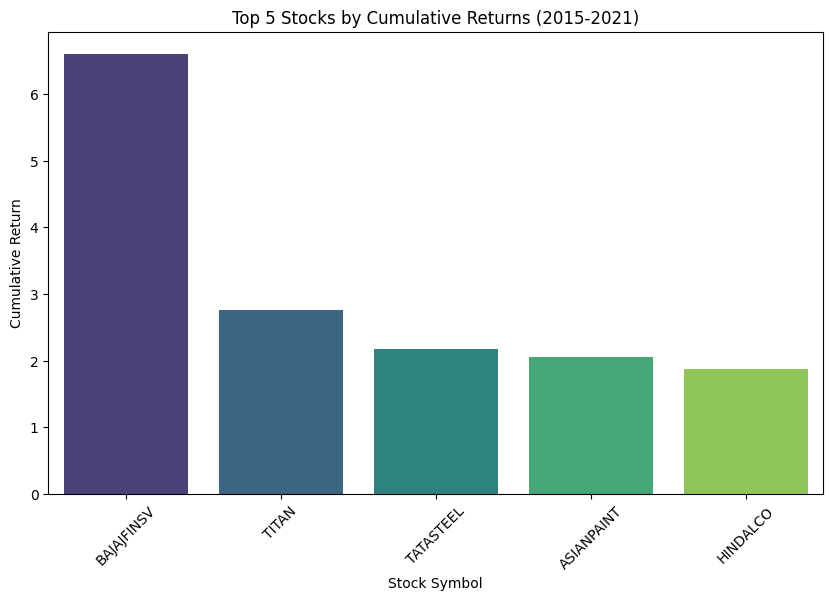

In [6]:
# Load metadata
metadata_df = pd.read_csv('/content/stock_metadata.csv')

# Calculate average daily returns per stock
avg_returns = last_decade_df.groupby('Symbol')['Returns'].mean()

# Calculate Sharpe ratio (risk-adjusted return, assuming risk-free rate = 0)
sharpe_ratio = avg_returns / volatility

# Calculate cumulative returns over the period
cumulative_returns = last_decade_df.groupby('Symbol')['Close'].agg(
    lambda x: (x.iloc[-1] / x.iloc[0]) - 1 if len(x) > 1 else np.nan
)

# Combine metrics into a DataFrame
portfolio_metrics = pd.DataFrame({
    'Avg_Daily_Returns': avg_returns * 252,  # Annualized
    'Volatility': volatility * np.sqrt(252),  # Annualized
    'Sharpe_Ratio': sharpe_ratio * np.sqrt(252),  # Annualized
    'Cumulative_Returns': cumulative_returns
}).dropna()

# Select top 5 stocks by cumulative returns
top_stocks = portfolio_metrics.sort_values('Cumulative_Returns', ascending=False).head(5)

# Merge with metadata for industry diversification
top_stocks_with_meta = top_stocks.merge(metadata_df[['Symbol', 'Industry']], on='Symbol')

# Display results
print("Top 5 Promising Stocks for Portfolio:")
print(top_stocks_with_meta)

# Visualize cumulative returns
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stocks.index, y=top_stocks['Cumulative_Returns'], hue=top_stocks.index, palette='viridis', legend=False)
plt.title('Top 5 Stocks by Cumulative Returns (2015-2021)')
plt.ylabel('Cumulative Return')
plt.xlabel('Stock Symbol')
plt.xticks(rotation=45)
plt.show()

### Interpretation

BAJAJFINSV led with a 660.37% cumulative return and the highest Sharpe ratio (1.1135), indicating strong risk-adjusted performance.
The portfolio includes diversification across Financial Services, Consumer Goods, and Metals sectors.

## Task 3: Analyze Correlation Between Selected Stocks

### Objective:
Evaluate correlations between the selected stocks to assess diversification benefits.

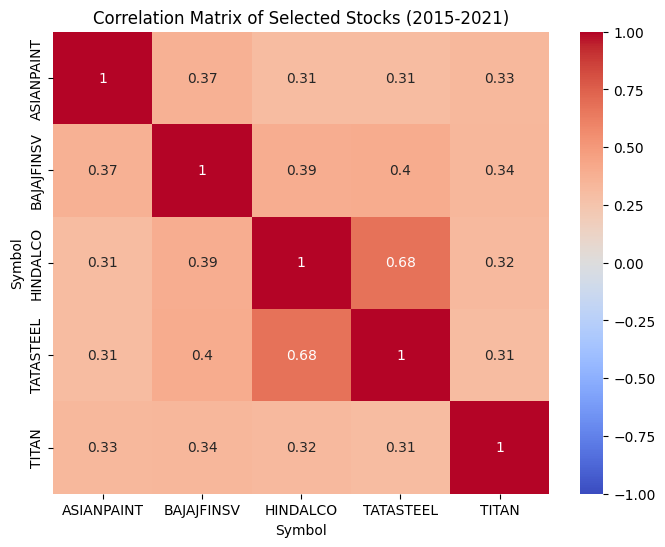

Correlation Matrix of Selected Stocks:
Symbol      ASIANPAINT  BAJAJFINSV  HINDALCO  TATASTEEL     TITAN
Symbol                                                           
ASIANPAINT    1.000000    0.371876  0.310393   0.305618  0.333778
BAJAJFINSV    0.371876    1.000000  0.394265   0.399801  0.339284
HINDALCO      0.310393    0.394265  1.000000   0.676922  0.320549
TATASTEEL     0.305618    0.399801  0.676922   1.000000  0.308150
TITAN         0.333778    0.339284  0.320549   0.308150  1.000000


In [7]:
# Filter data for the selected stocks
selected_stocks = ['BAJAJFINSV', 'TITAN', 'TATASTEEL', 'ASIANPAINT', 'HINDALCO']
selected_df = last_decade_df[last_decade_df['Symbol'].isin(selected_stocks)].copy()

# Pivot the data to have stocks as columns and daily returns as rows
returns_pivot = selected_df.pivot(index='Date', columns='Symbol', values='Returns')

# Calculate the correlation matrix
correlation_matrix = returns_pivot.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Selected Stocks (2015-2021)')
plt.show()

# Print the correlation matrix
print("Correlation Matrix of Selected Stocks:")
print(correlation_matrix)

### Interpretation

The highest correlation (0.6769) was between HINDALCO and TATASTEEL, both in the Metals sector, indicating they often move together.
Other correlations (0.30–0.40) suggest moderate diversification benefits, reducing overall portfolio risk.

## Task 4: Visualize Portfolio Performance

### Objective:

Compare the performance of an equal-weighted portfolio of the selected stocks to a benchmark (average of all stocks).

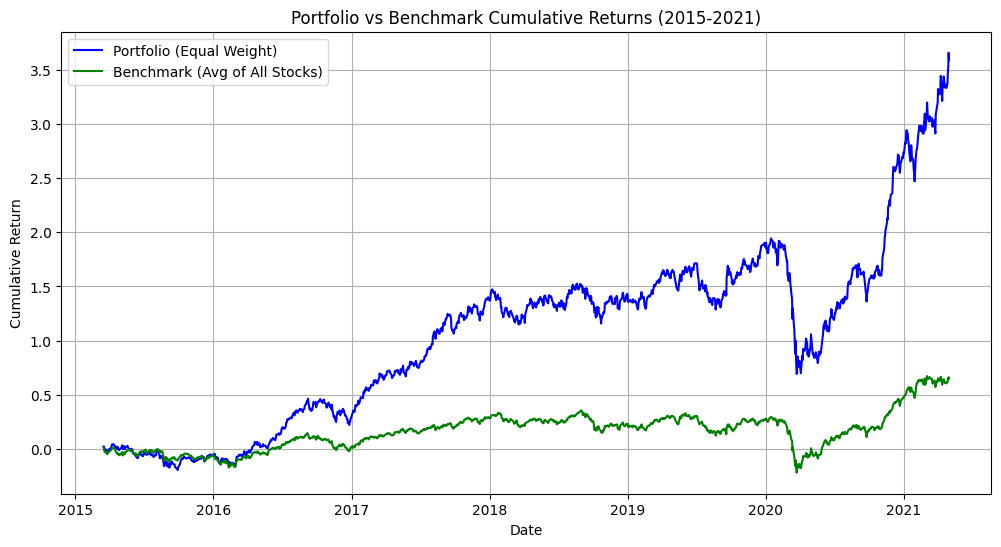

Final Cumulative Returns (2015-2021):
Portfolio: 3.5945
Benchmark: 0.6492


In [8]:
# Filter data for the selected stocks
selected_stocks = ['BAJAJFINSV', 'TITAN', 'TATASTEEL', 'ASIANPAINT', 'HINDALCO']
selected_df = last_decade_df[last_decade_df['Symbol'].isin(selected_stocks)].copy()

# Pivot the data to have stocks as columns and closing prices as rows
close_pivot = selected_df.pivot(index='Date', columns='Symbol', values='Close')

# Calculate daily returns for the selected stocks
portfolio_returns = close_pivot.pct_change()

# Assume equal weighting (20% each) for the portfolio
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
portfolio_daily_returns = portfolio_returns.dot(weights)

# Calculate cumulative returns for the portfolio
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod() - 1

# Calculate the benchmark (average of all stocks in the dataset as a proxy for Nifty 50)
benchmark_returns = last_decade_df.groupby('Date')['Returns'].mean()
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1

# Plot the portfolio vs benchmark
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio (Equal Weight)', color='blue')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark (Avg of All Stocks)', color='green')
plt.title('Portfolio vs Benchmark Cumulative Returns (2015-2021)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Print final cumulative returns
print("Final Cumulative Returns (2015-2021):")
print(f"Portfolio: {portfolio_cumulative_returns.iloc[-1]:.4f}")
print(f"Benchmark: {benchmark_cumulative_returns.iloc[-1]:.4f}")

### Interpretation

The portfolio achieved a 359.45% cumulative return, significantly outperforming the benchmark’s 64.92%.
The portfolio showed strong growth, especially post-2017, with a sharp recovery after the 2020 market crash.

## Task 5: Analyze Drawdowns and Risk

## Objective:

Assess the portfolio’s risk by calculating its maximum drawdown and comparing it to the benchmark.

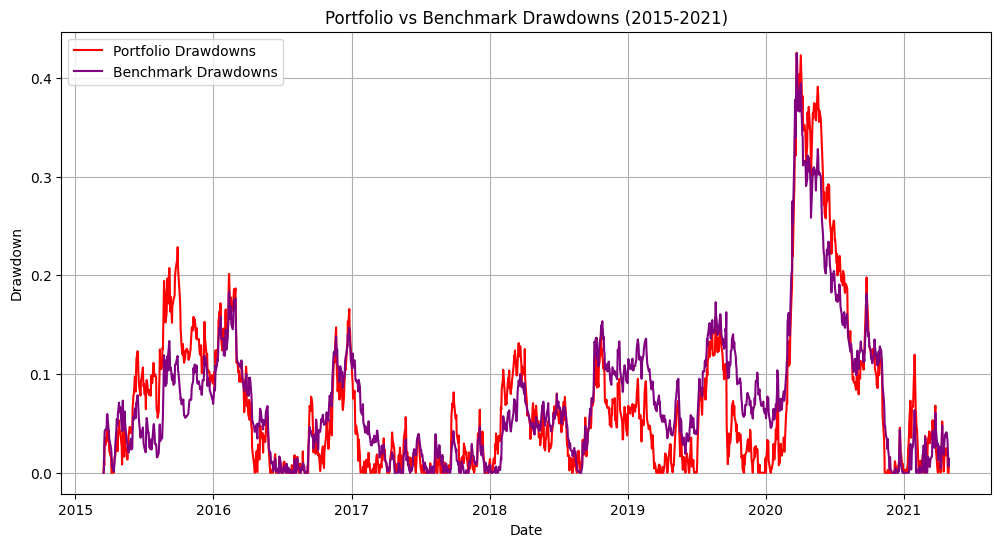

Maximum Drawdowns (2015-2021):
Portfolio: 0.4255
Benchmark: 0.4249


In [9]:
# Calculate drawdowns
# Portfolio drawdown: (peak - current) / peak
portfolio_peaks = portfolio_cumulative_returns.cummax()
portfolio_drawdowns = (portfolio_peaks - portfolio_cumulative_returns) / (1 + portfolio_peaks)

# Benchmark drawdown
benchmark_peaks = benchmark_cumulative_returns.cummax()
benchmark_drawdowns = (benchmark_peaks - benchmark_cumulative_returns) / (1 + benchmark_peaks)

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_drawdowns.index, portfolio_drawdowns, label='Portfolio Drawdowns', color='red')
plt.plot(benchmark_drawdowns.index, benchmark_drawdowns, label='Benchmark Drawdowns', color='purple')
plt.title('Portfolio vs Benchmark Drawdowns (2015-2021)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid()
plt.show()

# Print maximum drawdowns
print("Maximum Drawdowns (2015-2021):")
print(f"Portfolio: {portfolio_drawdowns.max():.4f}")
print(f"Benchmark: {benchmark_drawdowns.max():.4f}")

### Interpretation

The portfolio’s maximum drawdown (42.55%) was nearly identical to the benchmark’s (42.49%), indicating comparable downside risk.
Both experienced their largest drawdowns during the 2020 market crash, with the portfolio showing slightly more volatility in some periods.

## Conclusion

### Key Findings

#### Volatility:
Stocks like BAJFINANCE, JSWSTEEL, and EICHERMOT were the most volatile, while SSLT, VEDL, and ZEEL showed the largest daily price fluctuations.
Stock Selection: The top 5 stocks by cumulative returns were BAJAJFINSV (660.37%), TITAN (275.16%), TATASTEEL (216.98%), ASIANPAINT (204.91%), and HINDALCO (187.38%).

#### Diversification:
Correlations were moderate (0.30–0.40), except for a high correlation (0.6769) between HINDALCO and TATASTEEL, suggesting good diversification overall.
Performance: The equal-weighted portfolio achieved a 359.45% cumulative return, significantly outperforming the benchmark’s 64.92%.
Risk: The portfolio’s maximum drawdown (42.55%) was comparable to the benchmark’s (42.49%), indicating that the higher returns did not come at the cost of significantly higher downside risk.

#### Recommendations

The portfolio is well-suited for growth-oriented investors, offering high returns with a risk profile similar to the broader market.
To further reduce risk, consider replacing one of the Metals stocks (HINDALCO or TATASTEEL) with a stock from a less correlated sector (e.g., IT or Healthcare) or adjusting weights to favor less volatile stocks like ASIANPAINT.

#### Limitations

The analysis covers 2015 to 2021 due to data availability. Extending to 2025 could provide more recent insights.
The benchmark uses the average of all stocks as a proxy for the Nifty 50 index. Actual Nifty 50 data would improve accuracy.
Additional risk metrics (e.g., Value at Risk, beta) or portfolio optimization techniques could enhance the analysis.